In [2]:
import numpy as np
import pandas as pd
import os
import glob
import scipy 

In [ ]:
path = '/Volumes/LaCie/school/combine_lab/Data/squamous_carcinoma/'

cSCC_counts.txt file is a merged raw count matrix of all patients (after 10x cellranger processing and filtered: cells with <200 genes or >10% mitochondiral gene expression were rm).

Thus, separate by patient and output the saved file:

In [ ]:
# cSCC_counts = pd.read_csv(path+'scRNAseq/'+'GSE144236_cSCC_counts.txt', sep = '\t', chunksize=1000)

# # merge all chunks into one df
# scRNAseq = pd.concat([chunk for chunk in cSCC_counts])

# # split df by patient
# cSCC_scRNA = []
# for i, j in scRNAseq.groupby(scRNAseq.columns.str.split("_").str[0], axis=1):
#     cSCC_scRNA.append(j)
    
# # save df by patient idex to separate CSV files
# for i, j in scRNAseq.groupby(scRNAseq.columns.str.split("_").str[0], axis=1):
#     j.to_csv('Data/squamous_carcinoma/scRNAseq_{}.csv'.format(i), header=True, index_label=False)

In [ ]:
# squamous carcinoma dataset
path = '/Volumes/LaCie/school/combine_lab/Data/squamous_carcinoma/'

all_counts = pd.read_csv(path+'ST/'+'GSE144239_ST_all_counts.txt', sep = '\t')
st_barcodes = pd.read_csv(path+'ST/'+'GSE144239_ST_barcode_id.txt', sep = '\t', header=None)
visium = pd.read_csv(path+'ST/'+'GSE144239_ST_Visium_counts.txt', sep = '\t')

metadata = pd.read_csv(path+'scRNAseq/'+'GSE144236_patient_metadata_new.txt', sep = '\t')

In [ ]:
# read in all patient scRNAseq files
scRNA = [pd.read_csv(j, index_col=0) for j in glob.glob(os.path.join(path, '*.csv'))]

In [ ]:
range(len(scRNA)) # scRNA for 10 patients

In [ ]:
scRNA[0]

In [ ]:
all_counts

ST for P2, 5, 9 and 10 was generated with an older version of technology with larget spot size and center-to-center distance.

In [ ]:
st_keep = np.unique(all_counts.loc['Patient'].values)
print(st_keep)
# type(st_keep)
st_keep = st_keep.tolist()
st_keep = [int(i) for i in st_keep] # turn float to int
print(st_keep)

In [ ]:
np.unique(all_counts.loc['Section replicate'].values)

In [ ]:
print(type(scRNA))
print(type(scRNA[0]))

Keep only scRNA for patients 2, 5, 9, and 10

In [ ]:
scrna = []
for i in range(len(scRNA)):
    if scRNA[i].loc['Patient'].isin(st_keep).any():
        scrna.append(scRNA[i])
len(scrna)

In [ ]:
scrna[3]

In [ ]:
counts = []
for i in range(len(scrna)):
    counts.append(scrna[i].drop(['Patient', 'Tissue: 0=Normal, 1=Tumor'], axis=0)) # delete first two rows

In [ ]:
counts[0]

In [ ]:
from scipy.sparse import csr_matrix

def pd2csr(df):
    #from dense to sparse, use df.astype() with a SparseDtype
    spars_dtype = pd.SparseDtype(int, fill_value=0)
    spars_df = df.astype(spars_dtype)

    # convert to coo()
    df_coo = spars_df.sparse.to_coo()

    # convert to col sparse row matrix
    return csr_matrix((df_coo.data, (df_coo.row, df_coo.col)))

In [ ]:
spar_count = []
for i in range(len(counts)):
    spar_count.append(pd2csr(counts[i]))

In [ ]:
for i, j in enumerate(st_keep):
    scipy.sparse.save_npz(f"Data/squamous_carcinoma/scRNA_counts_P{j}.npz", spar_count[i])

process metadata

In [ ]:
keep = []
for i in range(len(counts)):
    keep.append(counts[i].columns.values)

keep = [l.tolist() for l in keep]
keep1list = [i for patient in keep for i in patient]
len(keep1list)

In [ ]:
# sanity check
print(len(keep[0]) + len(keep[1]) + len(keep[2]) + len(keep[3]))

In [ ]:
# keep only metadata values from patients of interest
meta = metadata.loc[keep1list, ]
meta

In [ ]:
meta.to_csv('Data/squamous_carcinoma/scRNAseq/metadata.csv')

10X Visium used for P4 and 6 (not at sc but better resolution than older version).

Note, spatial spot barcodes are also 16-oligo sequence.

In [ ]:
visium

### No data matches up with the st_barcodes...

In [ ]:
# split spot barcode on _ and keep just the ending
spt = []
for i in visium.columns:
    head, sep, tail = i.partition('_')
    spt.append(tail)

# split spot barcode on - and keep just first part
spot = []
for i in spt:
    spot.append(i.split('-', 1)[0])
np.unique(spot)

In [ ]:
# count number of unique spots
len(np.unique(spot))

In [ ]:
vs_spots = np.unique(spot).astype(object)
vs_spots

In [ ]:
st_barcodes

In [ ]:
st_barcodes.loc[:, 0].isin(vs_spots)

In [ ]:
st_barcodes[st_barcodes.loc[:, 0].isin(vs_spots)]

In [ ]:
print(np.unique(visium.iloc[0].values)) # find unique patients 
print(np.unique(visium.iloc[1].values)) # find unique replicates 

In [ ]:
# sanity check that filtering for barcodes in spots is indeed not the same
fake = pd.DataFrame({'spot': ['GTCCGATATGATTGCCGC', 'GCGACGCGGCATAGTTTA','AAACAAGTATCTCCCA', 'TTGTTTGTATTACACG'], #first 2 entries from st_barcodes, last 2 from vs_spots
                        'X': [0, 0, 0, 0]
                        })
fake.iloc[:, 0].isin(st_barcodes.iloc[:,0])
fake[fake.iloc[:,0].isin(st_barcodes.iloc[:,0])]

In [ ]:
# same same
st_barcodes.iloc[:,0].isin(fake.iloc[:,0])
st_barcodes[st_barcodes.iloc[:,0].isin(fake.iloc[:,0])]

In [ ]:
metadata

In [ ]:
# count number of unique spots from metadata
meta_barcds = [x.split('_')[2] for x in metadata.index] # split rownames on '_' and keep barcode only
np.unique(barcds).shape 

In [ ]:
meta_barcds

In [ ]:
# check if meta_barcds in st_barcodes
[i for e in meta_barcds for i in st_barcodes.iloc[:,0] if e in i] 

In [ ]:
# check if visium spots are in st_barcodes
[i for e in vs_spots for i in st_barcodes.iloc[:,0] if e in i] 

In [ ]:
# sanity check
[i for e in fake.iloc[:,0] for i in st_barcodes.iloc[:, 0] if e in i] 

In [ ]:
# just for fun, see which don't match (get length)
print(len(set(st_barcodes.iloc[:, 0])-{i for e in fake.iloc[:, 0] for i in st_barcodes.iloc[:, 0] if e in i}))
print(len(st_barcodes.iloc[:, 0]))

In [ ]:
# cSCC_counts = pd.read_csv(path+'scRNAseq/'+'GSE144236_cSCC_counts.txt', sep = '\t', chunksize=1000)

# # merge all chunks into one df
# scRNAseq = pd.concat([chunk for chunk in cSCC_counts])

# # check if any of the scRNA barcodes are in the st_barcodes
# [i for e in scRNAseq_barcds for i in st_barcodes.iloc[:,0] if e in i] 

In [ ]:
scRNAseq

In [ ]:
scRNAseq_barcds = [x.split('_')[2] for x in scRNAseq.columns.values]
scRNAseq_barcds

In [ ]:
[i for e in scRNAseq_barcds for i in st_barcodes.iloc[:,0] if e in i] 

In [ ]:
# scRNA in metadata? yes.
# [i for e in scRNAseq.columns.values.tolist() for i in metadata.index if e in i] 
print(len([i for e in scRNAseq.columns.values.tolist() for i in metadata.index if e in i]))
print(len(metadata))
print(len(scRNAseq.columns))

In [ ]:
metadata['patient'].unique()

In [ ]:
len(scRNA) # number of patients = 10 (as expected)

In [ ]:
all_counts.head()

In [ ]:
# similar genes in scRNAseq and ST_all_counts
[i for e in scRNAseq.index[2:] for i in all_counts.index[4:] if e in i]

## Explore sc MIBI files

In [6]:
!pip3 install seaborn

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
mibi = pd.read_csv('/Volumes/LaCie/school/combine_lab/Data/squamous_carcinoma/MIBI/MIBI_celltype_annotations.csv')
mibi = mibi.drop(['Unnamed: 0'], axis=1)
mibi

,cellLabelInImage,cellSize,C,Na,P,S,Fe,dsDNA,Vimentin,Histone H3,...,Au,PointNum,Patient,Patient_ID,cell_ID,cell_type_label,UMAP1,UMAP2,x_cent,y_cent
0,18,880,0.148559,0.068483,0.000000,0.099788,0.000000,0.264008,0.000000,0.167945,...,0.019230,1,21,T21,1,Keratinocyte,-6.147702,6.456697,48,1647
1,31,378,0.260486,0.116280,0.003285,0.087257,0.000000,0.068013,0.000000,0.000000,...,0.044384,1,21,T21,2,Keratinocyte,-9.814033,3.417595,86,1716
2,32,44,0.137596,0.388341,0.097597,0.174487,0.016519,0.498989,0.040052,0.000000,...,0.126007,1,21,T21,3,LeadingEdge,1.545935,7.002696,83,1395
3,33,86,0.148523,0.376953,0.147244,0.049857,0.010321,0.691183,0.028695,0.000000,...,0.073900,1,21,T21,4,Keratinocyte,-4.884752,7.030460,83,1390
4,38,459,0.206484,0.116933,0.018646,0.018416,0.000000,0.072283,0.000000,0.000000,...,0.117845,1,21,T21,5,Keratinocyte,-7.978457,5.535153,96,1652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41925,5175,242,0.919118,0.512533,0.269520,0.230953,0.486780,0.186843,1.000000,0.331656,...,0.005295,17,10,T10,41926,Macrophage,4.059627,0.524278,2043,805
41926,5176,250,0.836150,0.325590,0.087466,0.132499,0.120735,0.000000,0.587755,0.000000,...,0.000000,17,10,T10,41927,Fibroblast,5.902947,3.179222,2044,625
41927,5177,304,1.000000,0.470958,0.268910,0.375684,0.120004,0.334965,0.234593,0.514696,...,0.147798,17,10,T10,41928,DC,-3.387920,-4.110366,2043,1544
41928,5178,102,0.668463,0.324551,0.144754,0.029003,0.186271,0.000000,0.159233,0.000000,...,0.000000,17,10,T10,41929,LeadingEdge,-0.703066,5.113876,2045,330


In [6]:
mibi['Patient'].unique()

array([21, 26, 27, 23,  1, 10])

In [7]:
mibi['Patient_ID'].unique()

array(['T21', 'T26', 'T27', 'T23', 'T1', 'T10'], dtype=object)

In [8]:
mibi['PointNum'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [22]:
mibi['cell_type_label'].unique()

array(['Keratinocyte', 'LeadingEdge', 'OtherNonImmune', 'CyclingK',
       'Fibroblast', 'Neutrophil', 'OtherImmune', 'CD4', 'B',
       'Macrophage', 'CD8', 'Tregs', 'DC', 'NK', 'Endothelial',
       'HairFollicle'], dtype=object)

In [9]:
# split df by patient
mibi_split = []
for i, j in mibi.groupby(['Patient', 'PointNum']):
    mibi_split.append(j)

In [14]:
mibi_split[0]

,cellLabelInImage,cellSize,C,Na,P,S,Fe,dsDNA,Vimentin,Histone H3,...,Au,PointNum,Patient,Patient_ID,cell_ID,cell_type_label,UMAP1,UMAP2,x_cent,y_cent
20180,1,198,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,13,1,T1,20181,Neutrophil,3.925055,-5.249645,6,9
20181,2,179,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.829807,0.612485,...,1.000000,13,1,T1,20182,Macrophage,3.332275,1.105211,5,29
20182,4,148,1.000000,1.000000,0.391686,1.000000,1.000000,0.385411,0.967979,0.459095,...,0.206394,13,1,T1,20183,OtherNonImmune,6.567847,1.382024,4,82
20183,5,231,1.000000,1.000000,0.935563,1.000000,1.000000,0.987459,1.000000,0.969142,...,0.562545,13,1,T1,20184,Macrophage,3.135530,1.629100,8,102
20184,6,129,1.000000,1.000000,1.000000,1.000000,0.391771,1.000000,1.000000,1.000000,...,0.300218,13,1,T1,20185,CD8,1.903026,-2.628109,5,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24337,5447,128,0.429741,0.674205,0.162792,0.001374,0.103571,0.000000,0.042312,0.000000,...,0.048015,13,1,T1,24338,LeadingEdge,0.826364,7.117581,2044,242
24338,5449,209,0.821409,0.878961,0.400371,0.098720,0.125477,0.000000,0.000000,0.000000,...,0.269101,13,1,T1,24339,LeadingEdge,-0.868710,5.022679,2043,1688
24339,5451,145,0.865445,0.882967,0.446887,0.273663,0.047768,0.117312,0.000000,0.000000,...,0.328029,13,1,T1,24340,LeadingEdge,-1.461481,4.526612,2044,1974
24340,5453,83,0.799713,0.822398,0.252951,0.243035,0.116671,0.000000,0.615787,0.000000,...,1.000000,13,1,T1,24341,Neutrophil,5.852296,-3.792675,2045,816


In [56]:
import colorcet as cc

# get unique cell type labels
cell_labels = mibi['cell_type_label'].unique()

# list of colors in color palettes
rbg_vals = sns.color_palette(cc.glasbey, len(mibi['cell_type_label'].unique()))

# set colour dict
lab_colrs = dict(zip(cell_labels, rbg_vals))

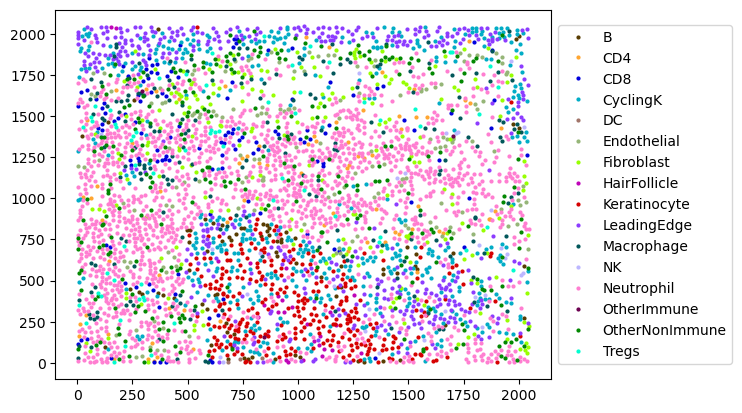

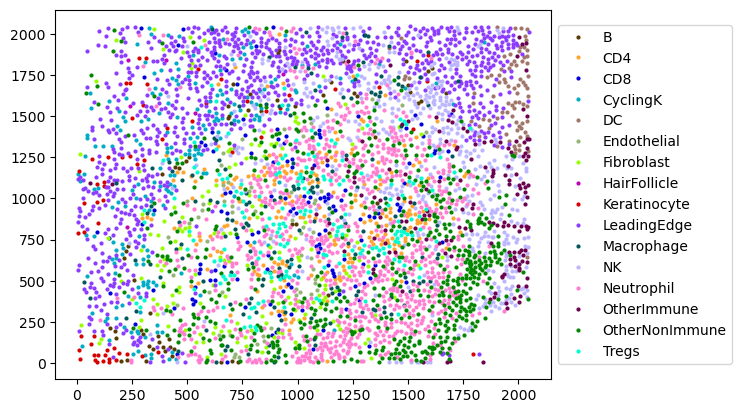

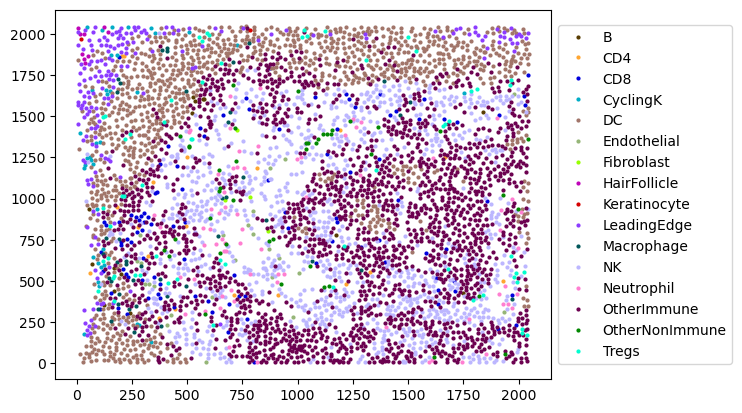

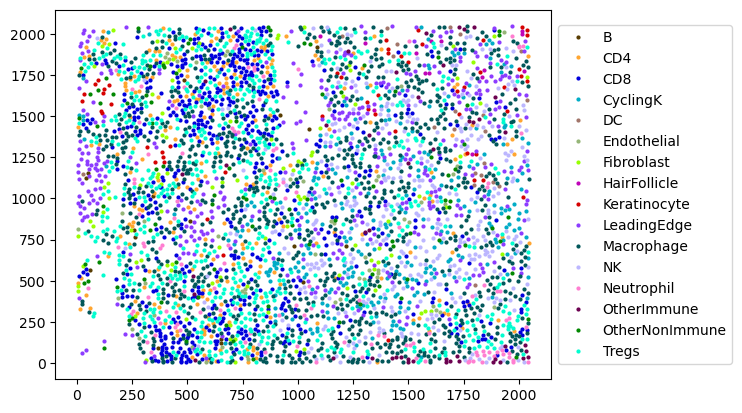

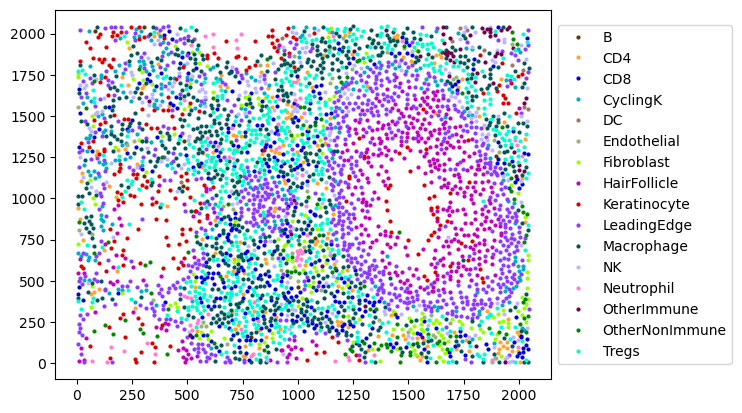

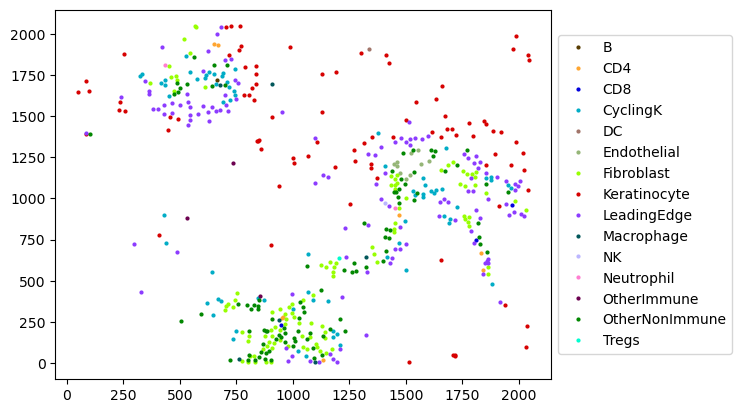

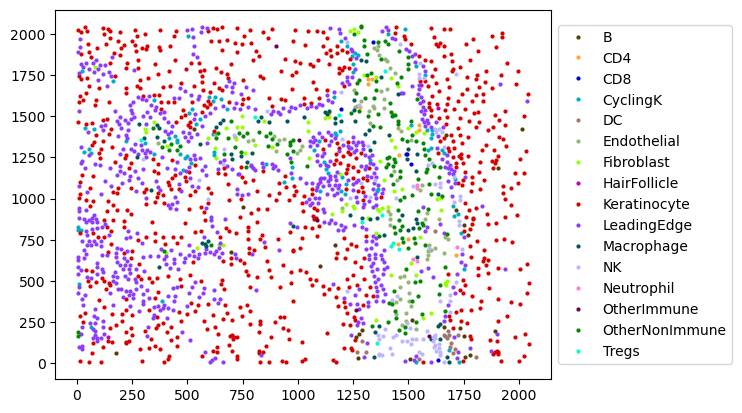

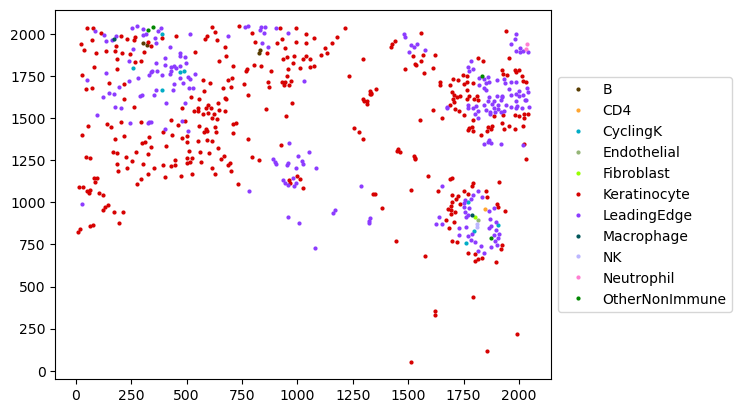

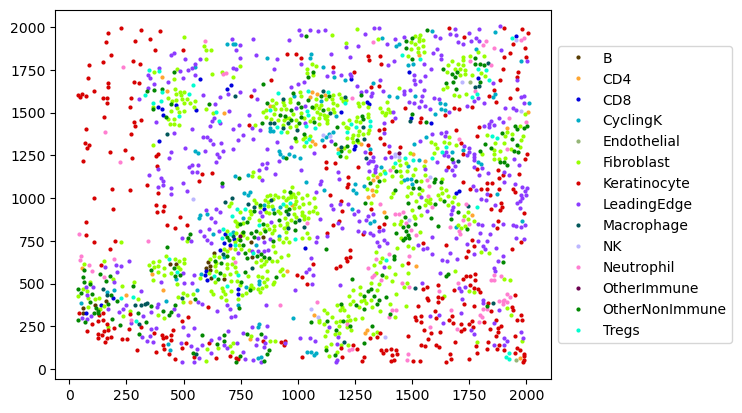

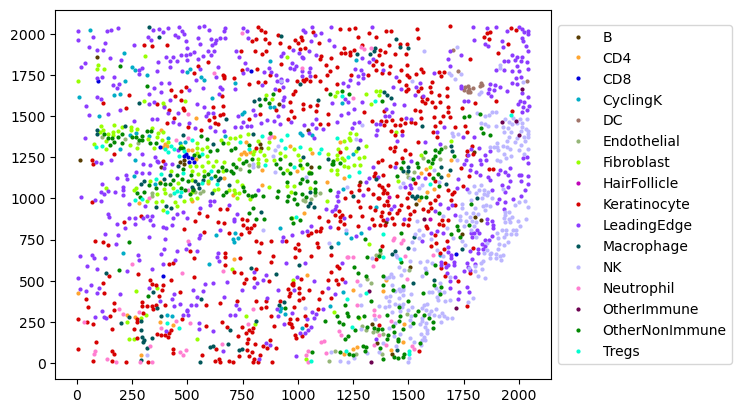

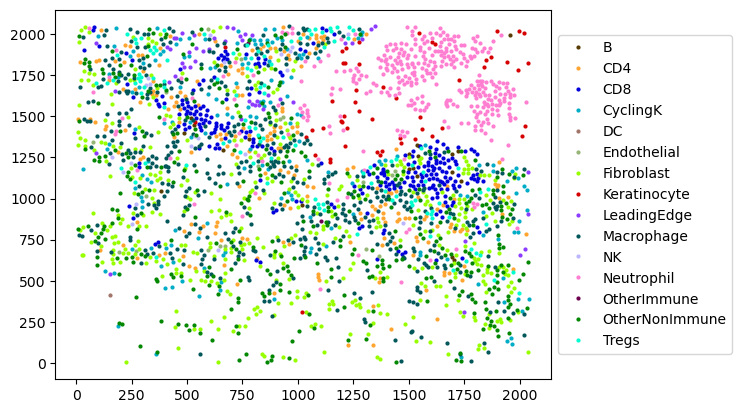

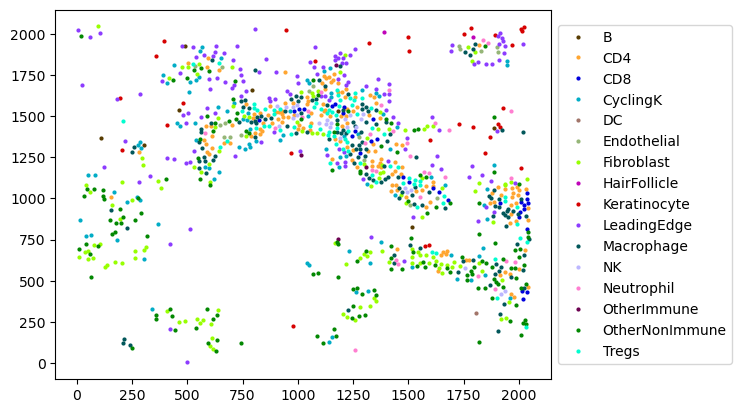

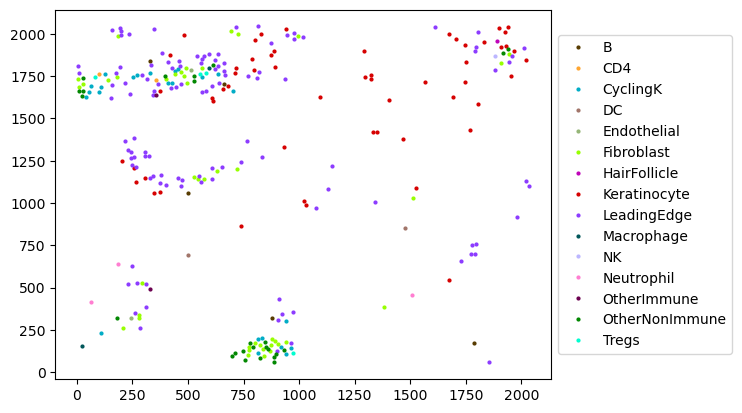

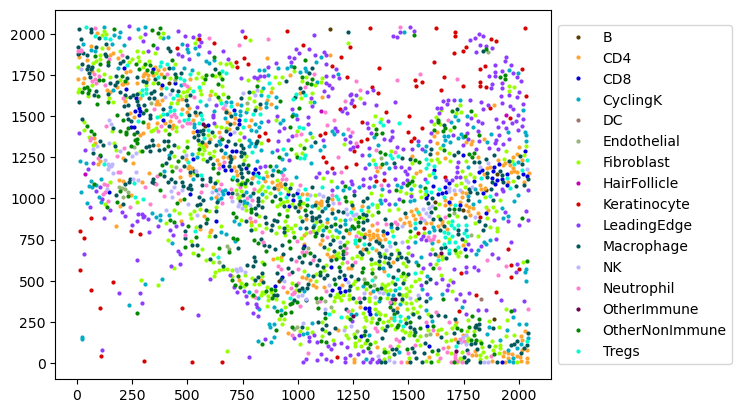

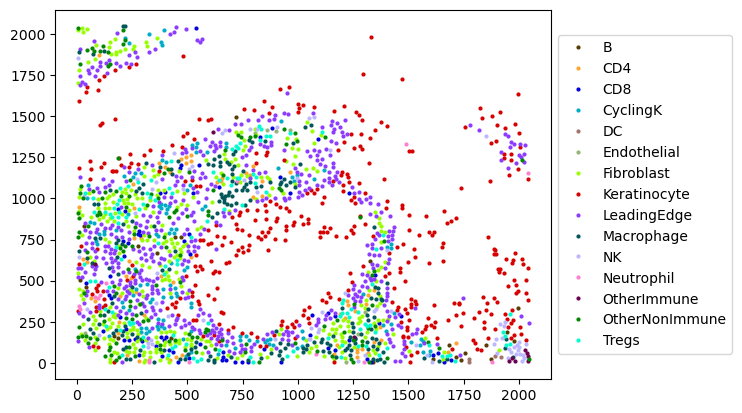

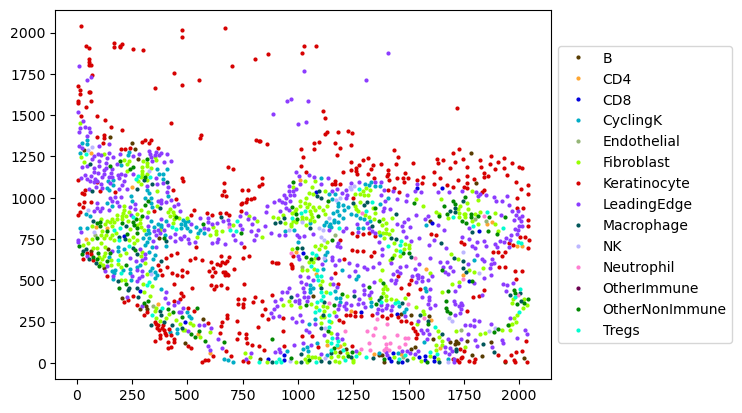

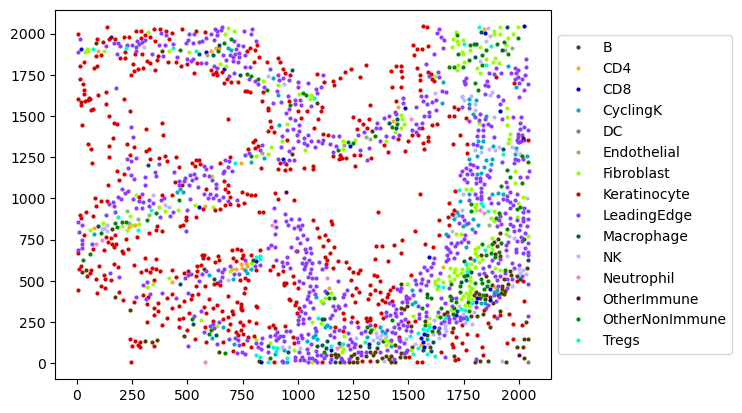

In [58]:
def plot_cells(df):
    cells = df.groupby('cell_type_label')
    for idx, cell in cells:
        plt.plot(cell['x_cent'], cell['y_cent'], marker='o', markersize=2, linestyle='', label=idx, color=lab_colrs[idx])
    plt.legend()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

for i in range(len(mibi_split)):
    plot_cells(mibi_split[i])